### Basic ISC Analysis

The goal of this analysis is to 'map out' regions that respond similarly to the speech across the entire audience. We will first load the fMRI data, which come as a matrix comprising data from 300 TRs (samples), 293 regions (different parts of the brain), and 68 listeners (i.e. subjects/participants). We will then - for each region - compute the overall similarity of the neural time series across the sample of listeners. We will visualize this by 'mapping the result back onto the brain'. We expect that listening to a speech/story should induce similar responses in auditory regions, regions involved in language, but also extralinguistic regions involved in social-cognition and narrative.

In [34]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pieman_utils import *


### Loading fMRI data and reshaping their order for ISC analysis

In [35]:
fmri_data = np.load('../data_pieman/fmri_data_pieman.npy')
print(fmri_data.shape)

data = fmri_data.copy()
data = np.swapaxes(data, 0,1)
data = np.swapaxes(data, 1,2)
print(data.shape)

(68, 300, 293)
(300, 293, 68)


### Loading the brain parcellation

(Note: this is only the 268 node Shen parcellation. You may wonder: Shouldn't this be 293? Yes - the reason is that we added additional anatomical regions for extracting neural time series. Thus, everying that goes beyond the 268 corresponds to regions like the N. accumbens, the Locus Coeruleus, etc.

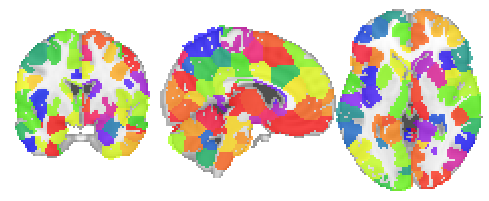

In [36]:
shen_file       = '../data_pieman/shen_2mm_268_parcellation.nii'

nilearn.plotting.plot_roi(shen_file, 
                  annotate = False, 
                  cut_coords = (5,0,0),
                  cmap = 'prism',
                  draw_cross = False, 
                  #title= 'Shen-268-node parcellation',
                 );
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);

sample_file = '../data_pieman/func.nii'
shen_masker.fit_transform(sample_file);

### Computing ISC and visualizing the ISC strenght in 'brain space'

Note: the "pieman_isc" function is actually pretty complex. We've outsourced it to a separate function that can be found in the pieman_utils.py file.

In [37]:
ISC = pieman_isc(data, pairwise=True, summary_statistic = np.mean, verbose=False)
ISC.shape

ISC[np.isnan(ISC)] = 0

#alpha = .05
# Get q-values (i.e., FDR-controlled p-values) using statsmodels
#q = multipletests(p[0, :], method='fdr_by')[1]
#corrected = q[np.newaxis, :] < alpha
#ISC[corrected == False] = 0


/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


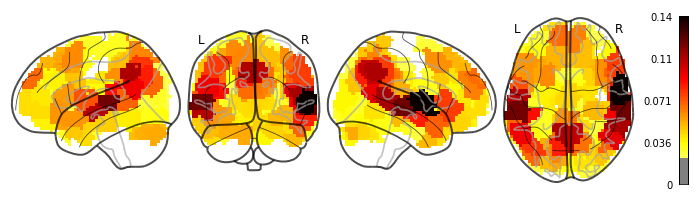

In [38]:
res_img = shen_masker.inverse_transform(ISC[:268]);

plotting.plot_glass_brain( nilearn.image.index_img(res_img,0) ,
                          display_mode = 'lyrz',
                          colorbar = 'True',
                         );

We observe that, as we predicted, ISC is strongest in auditory regions and extends into linguistic and extralinguistic regions.


### From here on, we explore the ISC-result in terms of individual brain regions and their specific signal time courses

First, since the ISC is a 'vector' of size 293, we can plot this vector and get a grip on where we see a maximum. Note that this can be done much better by associating the result with region names, whcih is currently lacking. 
However, the peak at region # 61, for instance, corresponds to a parcel around the auditory cortex (Superior Temporal Gyrus/Heschl).

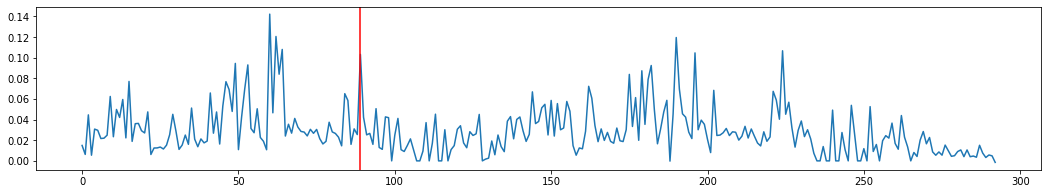

In [39]:
plt.figure(figsize = (18,3))
plt.plot(ISC.T);
plt.axvline(89, color = 'red')

### Let's plot the time-course from region 183 - and also a map of where that region is located.

0.6331274221665713


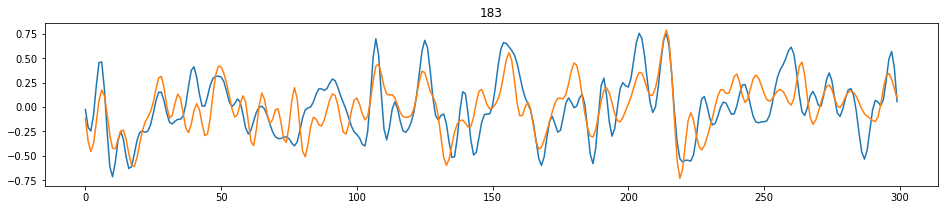

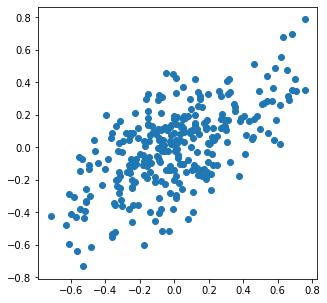

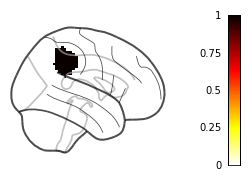

In [40]:
m1 = np.mean(data[:,:, :34], axis =2)
m2 = np.mean(data[:,:, 34:], axis =2)

curr_roi = 183

plt.figure(figsize = (16,3))

plt.plot(m1[:,curr_roi]);
plt.plot(m2[:,curr_roi]);
plt.title(str(curr_roi))
print(np.corrcoef(m1[:,curr_roi], m2[:,curr_roi])[0,1])

plt.figure(figsize = (5,5))
plt.scatter(m1[:,curr_roi],
           m2[:,curr_roi])

roi_vec = np.zeros((1,268))
roi_vec[0,curr_roi] = 1
roi_img = shen_masker.inverse_transform(roi_vec);
plotting.plot_glass_brain( nilearn.image.index_img(roi_img,0) ,
                          display_mode = 'x',
                          colorbar = 'True',
                         ) #'''

Ah, ok! It is about the TPJ.

### HEAP .... Accumbens...

In [41]:
#Pauli
subcortex = nilearn.datasets.fetch_atlas_pauli_2017()
pauli_masker = input_data.NiftiMapsMasker(subcortex.maps[2]);
sample_file = '../data_pieman/func.nii'
#pauli_masker.fit_transform(sample_file);


0.49853948412991356


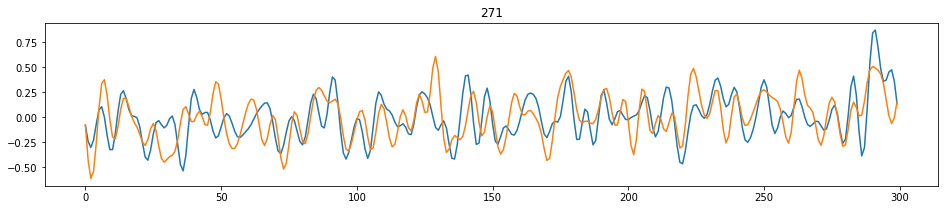

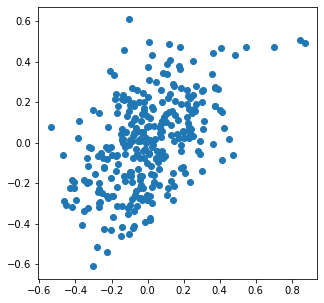

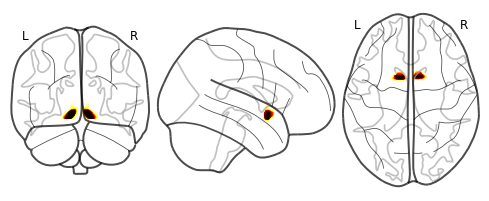

In [43]:
m1 = np.mean(data[:,:, :34], axis =2)
m2 = np.mean(data[:,:, 34:], axis =2)

curr_roi = 271

plt.figure(figsize = (16,3))

plt.plot(m1[:,curr_roi]);
plt.plot(m2[:,curr_roi]);
plt.title(str(curr_roi))
print(np.corrcoef(m1[:,curr_roi], m2[:,curr_roi])[0,1])

plt.figure(figsize = (5,5))
plt.scatter(m1[:,curr_roi],
           m2[:,curr_roi])


plotting.plot_glass_brain(nilearn.image.index_img(subcortex.maps, 2))

In [48]:
ISC[0, 271]

0.022682414949917667